# Credit Card Fraud Detection — A Pipeline Journey

## Overview
This notebook builds a fraud detection pipeline with time-aware evaluation, calibrated probabilities, and explicit threshold policies.

## The Story  
Less than **0.2% of transactions are fraudulent** — yet they cost banks **billions of dollars globally every year**.  
Detecting fraud is like finding a needle in a haystack: only **492 frauds out of 284,807 transactions** in this dataset.  

This project builds a pipeline that **learns from time-based patterns and hidden signals** to flag fraud in real-world credit card payments.  
Think of it as a **first line of defense** for banks, where every decision threshold is a trade-off:  
catching more fraudsters vs. minimizing false alarms that annoy customers.

This notebook doesn’t aim to squeeze every last bit of accuracy, but to mimic how a fraud analytics team would actually evaluate and trust a model before putting it into production.

## The Approach
- **Dataset:** 284,807 transactions with severe class imbalance.  
- **Methodology:**  
  - **EDA:** amount distributions & temporal patterns (hours, day-parts).  
  - **Feature Engineering:** `Hour`, `Night_transaction`, `Business_hours`, `log(Amount)`.  
  - **Models:** Logistic, Random Forest, XGBoost, plus **Isotonic Calibration** via **TimeSeriesSplit**.  
  - **Decision Tuning:** either **Precision ≥90%** (customer experience) or **Min-Cost** (loss vs. investigation).  
- **Key Metrics:** **AUPRC (AP)** as the main yardstick; plus **ROC-AUC**, **Brier**, **ECE**, and **Cost-based thresholds**.

---

### Why AUPRC?
Under severe imbalance, **ROC-AUC** can look deceptively high (most negatives are easy). **AUPRC** emphasizes precision–recall on the *minority* class, aligning with how fraud teams feel model quality (missed fraud vs. false alarms).

### Reproducibility & Split
All results are on a **held-out test window** from a **time-ordered split** (avoid look-ahead leakage). Probabilities are **calibrated** with **isotonic regression** using **TimeSeriesSplit(cv=3)** on training only, improving reliability (lower **Brier**) and making thresholds meaningful.

**Note:** Thresholds were always chosen on the validation set and reported only on the held-out test window.  
This ensures no information leakage and keeps test results unbiased.

### Cost Assumptions for Decisions
Operating points are evaluated under illustrative costs (e.g., **FN = $200**, **FP = $5**). Replace with your actual costs to align decisions with business impact.

**Note:** The $200 / $5 costs are purely illustrative.  
Try sensitivity analysis with your own FN/FP costs to see how the optimal threshold shifts.

In practice, it’s eye-opening to change FN/FP costs to values closer to your business reality.  
Even small tweaks can flip which threshold — or even which model — is preferred.


---

## What you’ll get from this notebook
- A leakage-safe, time-aware evaluation setup.  
- Feature engineering that captures human/business rhythms.  
- Multiple models + **probability calibration** for trustworthy scores.  
- **Two operating modes:** Precision-first and Cost-minimum.  
- Clear **side-by-side summaries** and **confusion matrices** at chosen thresholds.

*Next: run the Setup cell to install dependencies and import libraries, then EDA → Modeling → Calibration → Threshold Tuning → Cost Analysis → Final Summary.*


In [57]:
%%capture
try:
    import imblearn, xgboost, sklearn
except Exception:
    %pip install -q --upgrade scikit-learn==1.4.2 imbalanced-learn==0.12.3 xgboost==2.1.1


# Import Libraries

In [58]:
import warnings, os, json, math, sys
import numpy as np, pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from pathlib import Path
from IPython.display import display

from sklearn.model_selection import TimeSeriesSplit
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.calibration import CalibratedClassifierCV, calibration_curve

from sklearn.metrics import (
    roc_auc_score, average_precision_score, precision_recall_curve, roc_curve, auc,
    f1_score, precision_score, recall_score, confusion_matrix, brier_score_loss
)

from imblearn.pipeline import Pipeline as ImbPipeline
from imblearn.over_sampling import SMOTE
from imblearn.under_sampling import RandomUnderSampler
from imblearn.combine import SMOTETomek

from xgboost import XGBClassifier

warnings.filterwarnings("ignore")
sns.set_context("notebook")
plt.rcParams["figure.figsize"]=(10,5)

SEED = 42
np.random.seed(SEED)

# Business cost assumptions (tune as needed)
COST_FP = 5.0     # investigation cost per false alert
COST_FN = 200.0   # average loss per missed fraud



## Load Data

In [ ]:
from pathlib import Path
import pandas as pd

def resolve_creditcard_csv() -> Path:
    candidates = [
        Path("data/raw/creditcard.csv"),
        Path("data/raw/creditcard.csv.gz"),
        Path("/kaggle/input/creditcardfraud/creditcard.csv"),
        Path("/kaggle/input/creditcard-fraud-detection/creditcard.csv"),
    ]
    for p in candidates:
        if p.exists():
            return p
    raise FileNotFoundError(
        "Could not find creditcard.csv.\n"
        "Local: place it at data/raw/creditcard.csv\n"
        "Kaggle: ensure the input dataset provides /kaggle/input/creditcardfraud/creditcard.csv"
    )

csv_path = resolve_creditcard_csv()
df = pd.read_csv(csv_path)
print(f"Loaded: {csv_path} | shape={df.shape}")


## Initial Data Exploration

In [60]:
df.head()

,Time,V1,V2,V3,V4,V5,V6,V7,V8,V9,...,V21,V22,V23,V24,V25,V26,V27,V28,Amount,Class
0,0.0,-1.359807,-0.072781,2.536347,1.378155,-0.338321,0.462388,0.239599,0.098698,0.363787,...,-0.018307,0.277838,-0.110474,0.066928,0.128539,-0.189115,0.133558,-0.021053,149.62,0
1,0.0,1.191857,0.266151,0.166480,0.448154,0.060018,-0.082361,-0.078803,0.085102,-0.255425,...,-0.225775,-0.638672,0.101288,-0.339846,0.167170,0.125895,-0.008983,0.014724,2.69,0
2,1.0,-1.358354,-1.340163,1.773209,0.379780,-0.503198,1.800499,0.791461,0.247676,-1.514654,...,0.247998,0.771679,0.909412,-0.689281,-0.327642,-0.139097,-0.055353,-0.059752,378.66,0
3,1.0,-0.966272,-0.185226,1.792993,-0.863291,-0.010309,1.247203,0.237609,0.377436,-1.387024,...,-0.108300,0.005274,-0.190321,-1.175575,0.647376,-0.221929,0.062723,0.061458,123.50,0
4,2.0,-1.158233,0.877737,1.548718,0.403034,-0.407193,0.095921,0.592941,-0.270533,0.817739,...,-0.009431,0.798278,-0.137458,0.141267,-0.206010,0.502292,0.219422,0.215153,69.99,0


In [61]:
display(df.info())


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 284807 entries, 0 to 284806
Data columns (total 31 columns):
 #   Column  Non-Null Count   Dtype  
---  ------  --------------   -----  
 0   Time    284807 non-null  float64
 1   V1      284807 non-null  float64
 2   V2      284807 non-null  float64
 3   V3      284807 non-null  float64
 4   V4      284807 non-null  float64
 5   V5      284807 non-null  float64
 6   V6      284807 non-null  float64
 7   V7      284807 non-null  float64
 8   V8      284807 non-null  float64
 9   V9      284807 non-null  float64
 10  V10     284807 non-null  float64
 11  V11     284807 non-null  float64
 12  V12     284807 non-null  float64
 13  V13     284807 non-null  float64
 14  V14     284807 non-null  float64
 15  V15     284807 non-null  float64
 16  V16     284807 non-null  float64
 17  V17     284807 non-null  float64
 18  V18     284807 non-null  float64
 19  V19     284807 non-null  float64
 20  V20     284807 non-null  float64
 21  V21     28

None

In [62]:
display(df.describe().T)


,count,mean,std,min,25%,50%,75%,max
Time,284807.0,9.481386e+04,47488.145955,0.000000,54201.500000,84692.000000,139320.500000,172792.000000
V1,284807.0,1.168375e-15,1.958696,-56.407510,-0.920373,0.018109,1.315642,2.454930
V2,284807.0,3.416908e-16,1.651309,-72.715728,-0.598550,0.065486,0.803724,22.057729
V3,284807.0,-1.379537e-15,1.516255,-48.325589,-0.890365,0.179846,1.027196,9.382558
V4,284807.0,2.074095e-15,1.415869,-5.683171,-0.848640,-0.019847,0.743341,16.875344
V5,284807.0,9.604066e-16,1.380247,-113.743307,-0.691597,-0.054336,0.611926,34.801666
V6,284807.0,1.487313e-15,1.332271,-26.160506,-0.768296,-0.274187,0.398565,73.301626
V7,284807.0,-5.556467e-16,1.237094,-43.557242,-0.554076,0.040103,0.570436,120.589494
V8,284807.0,1.213481e-16,1.194353,-73.216718,-0.208630,0.022358,0.327346,20.007208
V9,284807.0,-2.406331e-15,1.098632,-13.434066,-0.643098,-0.051429,0.597139,15.594995


In [63]:
print("Shape:", df.shape)


Shape: (284807, 31)


# Data Cleaning

In [64]:
print(df.columns.tolist())


['Time', 'V1', 'V2', 'V3', 'V4', 'V5', 'V6', 'V7', 'V8', 'V9', 'V10', 'V11', 'V12', 'V13', 'V14', 'V15', 'V16', 'V17', 'V18', 'V19', 'V20', 'V21', 'V22', 'V23', 'V24', 'V25', 'V26', 'V27', 'V28', 'Amount', 'Class']


## Check missing values


In [65]:
print("Missing values:\n", df.isnull().sum())

Missing values:
 Time      0
V1        0
V2        0
V3        0
V4        0
V5        0
V6        0
V7        0
V8        0
V9        0
V10       0
V11       0
V12       0
V13       0
V14       0
V15       0
V16       0
V17       0
V18       0
V19       0
V20       0
V21       0
V22       0
V23       0
V24       0
V25       0
V26       0
V27       0
V28       0
Amount    0
Class     0
dtype: int64


In [66]:
print("Duplicates:", df.duplicated().sum())
df = df.drop_duplicates().reset_index(drop=True)


Duplicates: 1081


# Feature Engineering

In [67]:
# Time-derived proxies (Time = seconds-from-start, not real timestamps)

df['Hour_from_start_mod24'] = ((df['Time'] // 3600) % 24).astype(int)
df['is_night_proxy'] = df['Hour_from_start_mod24'].isin([22,23,0,1,2,3,4,5]).astype(int)
df['is_business_hours_proxy'] = df['Hour_from_start_mod24'].between(9,17).astype(int)

df['_log_amount'] = np.log1p(df['Amount'])


features = [c for c in df.columns if c.startswith("V")] + [
    'Amount','_log_amount',
    'Hour_from_start_mod24','is_night_proxy','is_business_hours_proxy'
]
target = "Class"



# Exploratory Data Analysis (EDA)

# Imbalance + Pie

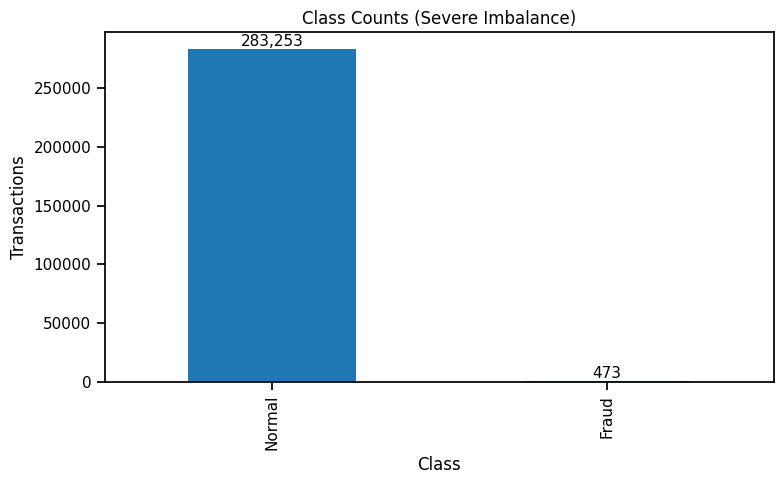

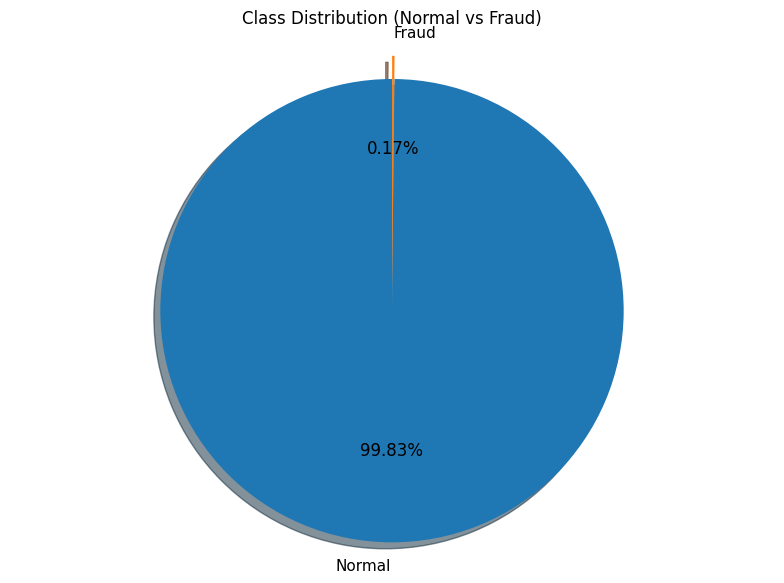

In [ ]:
counts = df['Class'].value_counts().rename({0:'Normal', 1:'Fraud'})
fig, ax = plt.subplots(figsize=(8,5))
counts.plot(kind='bar', ax=ax)
for i, v in enumerate(counts.values):
    ax.text(i, v, f"{v:,}", ha='center', va='bottom', fontsize=11)
ax.set_title('Class Counts (Severe Imbalance)')
ax.set_ylabel('Transactions'); ax.set_xlabel('Class')
plt.tight_layout()
plt.show()

# pie chart
fig, ax = plt.subplots(figsize=(8,6))
ax.pie(counts.values, labels=counts.index, autopct='%1.2f%%', startangle=90, explode=[0,0.1], shadow=True)
ax.set_title('Class Distribution (Normal vs Fraud)')
ax.axis('equal')
plt.tight_layout()
plt.show()


## Amount distribution

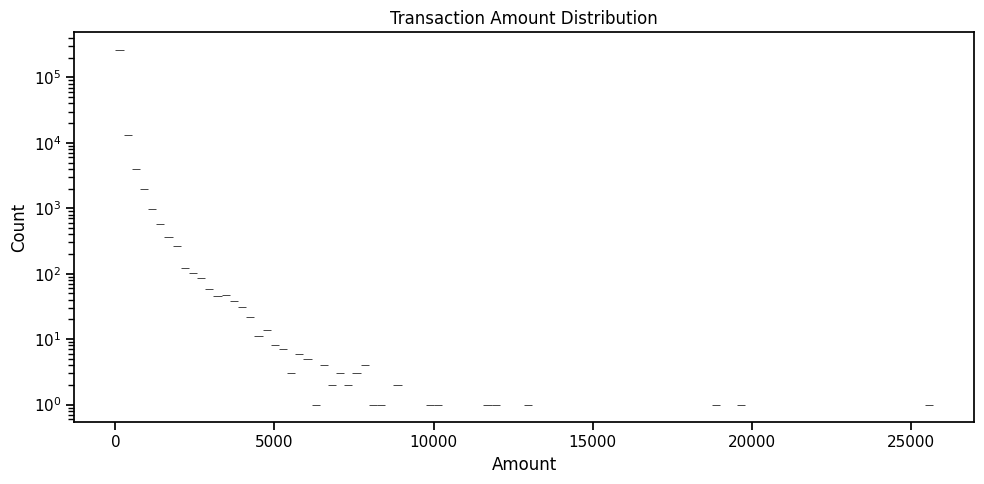

In [69]:
sns.histplot(df["Amount"], bins=100, log_scale=(False, True))
plt.title("Transaction Amount Distribution")
plt.tight_layout()
plt.show()

## log1p(Amount) — Class Separation

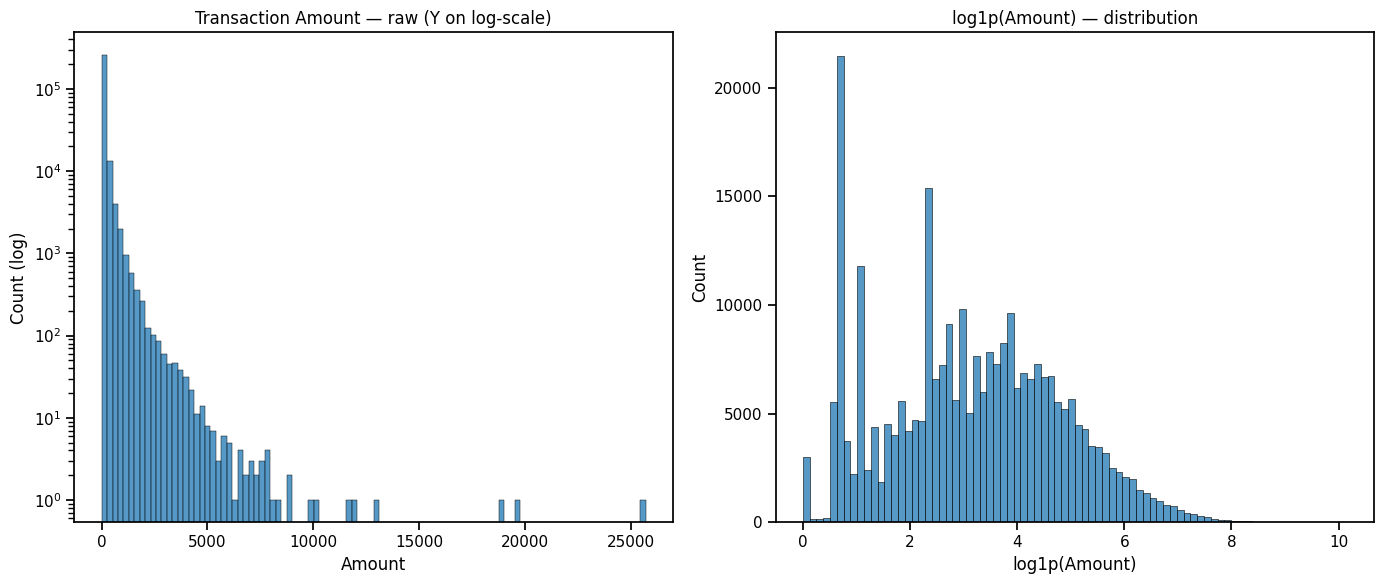

In [70]:
fig, axes = plt.subplots(1, 2, figsize=(14, 6))

# Raw amount, log-scaled Y
sns.histplot(df["Amount"], bins=100, ax=axes[0])
axes[0].set_yscale("log")
axes[0].set_title("Transaction Amount — raw (Y on log-scale)")
axes[0].set_xlabel("Amount")
axes[0].set_ylabel("Count (log)")

# Log-transformed feature on X
sns.histplot(df["_log_amount"], bins=80, ax=axes[1])
axes[1].set_title("log1p(Amount) — distribution")
axes[1].set_xlabel("log1p(Amount)")
axes[1].set_ylabel("Count")

plt.tight_layout()
plt.show()


### Left: “Raw amount with a logarithmic Y-axis to reveal the long tail of transaction counts without altering the original magnitude on X.”

### Right: “Distribution of log1p(Amount). The log transform reduces skewness and makes patterns easier to model and compare.”

## Fraud Rate by Hour

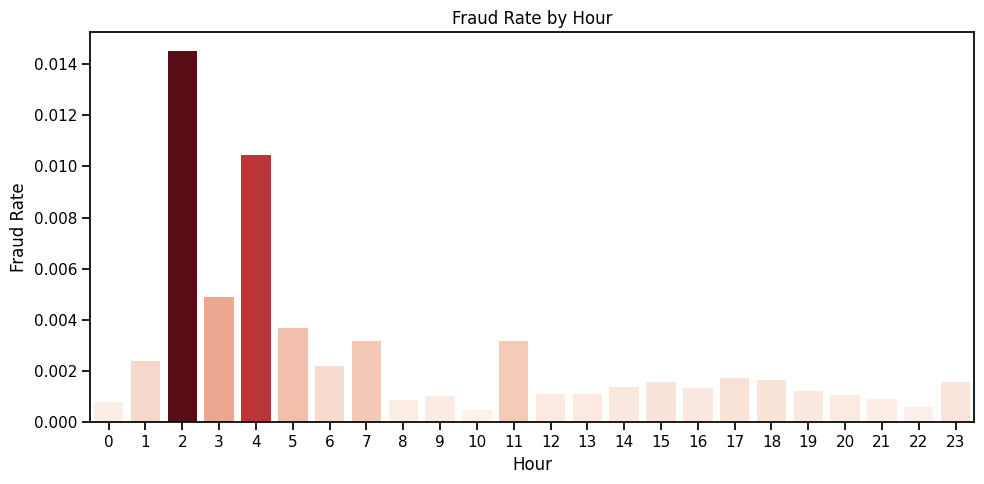

In [71]:
fraud_by_hour = df.groupby("Hour_from_start_mod24")["Class"].mean()

cmap = sns.color_palette("Reds", as_cmap=True)
vals = (fraud_by_hour / fraud_by_hour.max()).values
pal = [cmap(v) for v in vals]

sns.barplot(x=fraud_by_hour.index, y=fraud_by_hour.values, palette=pal)
plt.title("Fraud Rate by Hour")
plt.xlabel("Hour")
plt.ylabel("Fraud Rate")
plt.tight_layout()
plt.show()

## Transactions per Hour

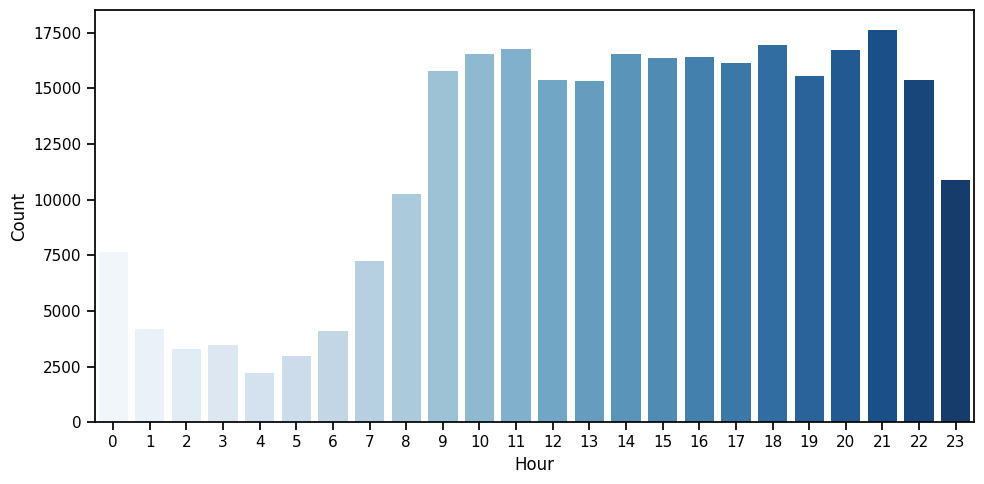

In [72]:
tx_by_hour = df.groupby("Hour_from_start_mod24")[target].count()
sns.barplot(x=tx_by_hour.index, y=tx_by_hour.values, palette='Blues')
plt.xlabel('Hour')
plt.ylabel("Count")
plt.tight_layout()
plt.show()

## Boxplot: Amount by Class

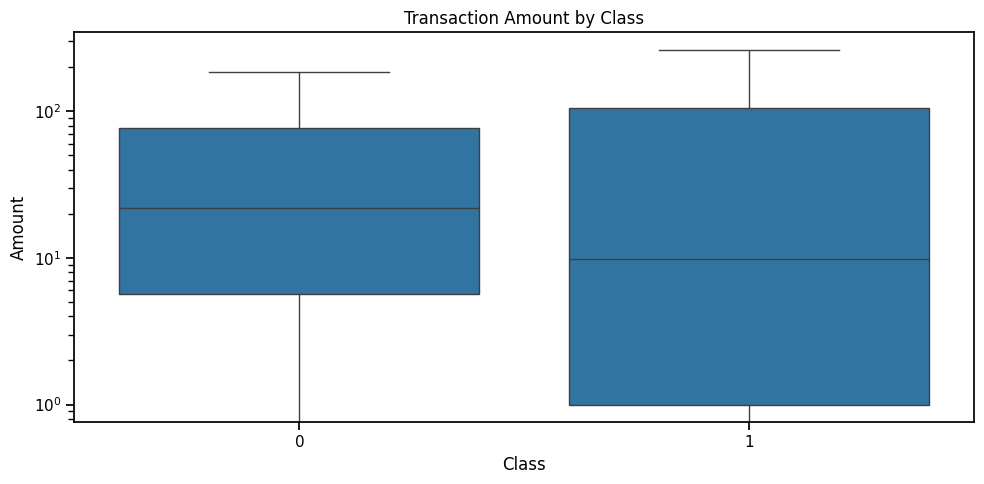

In [73]:
sns.boxplot(x= "Class", y="Amount" , data=df , showfliers=False)
plt.yscale("log")
plt.title("Transaction Amount by Class")
plt.tight_layout()
plt.show()

## Amount deciles vs fraud rate

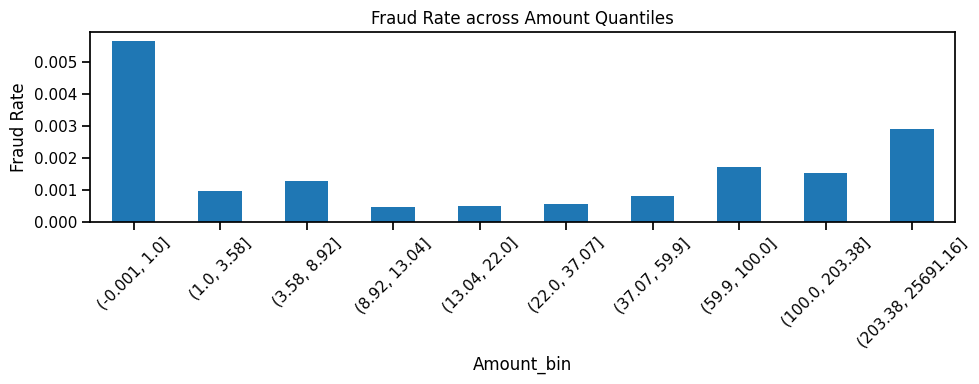

In [74]:
df["Amount_bin"] = pd.qcut(df["Amount"], q=10, duplicates="drop")
fraud_rate_bins = df.groupby("Amount_bin")["Class"].mean()
fraud_rate_bins.plot(kind="bar", figsize=(10,4))
plt.title("Fraud Rate across Amount Quantiles")
plt.ylabel("Fraud Rate")
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()


# Correlation matrix 

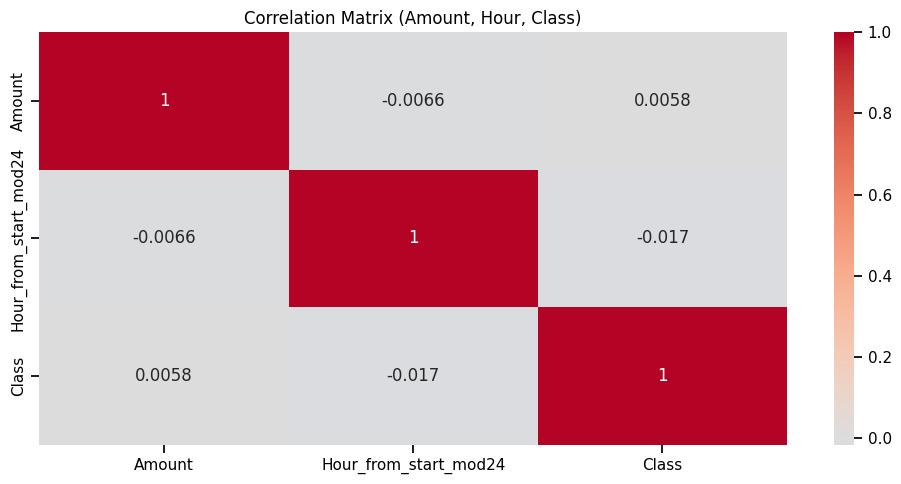

In [75]:
sns.heatmap(df[["Amount","Hour_from_start_mod24","Class"]].corr(), annot=True, cmap="coolwarm", center=0)
plt.title("Correlation Matrix (Amount, Hour, Class)")
plt.tight_layout()
plt.show()


## Time Segments (Morning / Afternoon / Evening / Night)

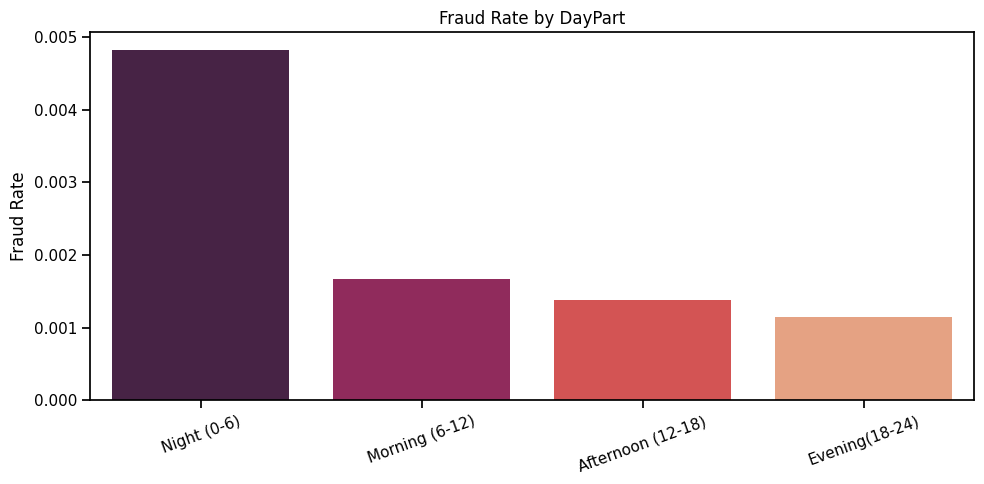

In [76]:
bins   = [0,6,12,18,24]
labels = ["Night (0-6)", "Morning (6-12)", "Afternoon (12-18)", "Evening(18-24)"]
df["DayPart"] = pd.cut(df["Hour_from_start_mod24"], bins=bins, labels=labels, right=False, include_lowest=True)


fraud_by_part  = df.groupby("DayPart")["Class"].mean().reindex(labels)

sns.barplot(x=fraud_by_part.index, y=fraud_by_part.values, palette="rocket")
plt.xticks(rotation=20)
plt.title("Fraud Rate by DayPart")
plt.xlabel("")
plt.ylabel("Fraud Rate")
plt.tight_layout()
plt.show()

## Heatmap for Hour Rate

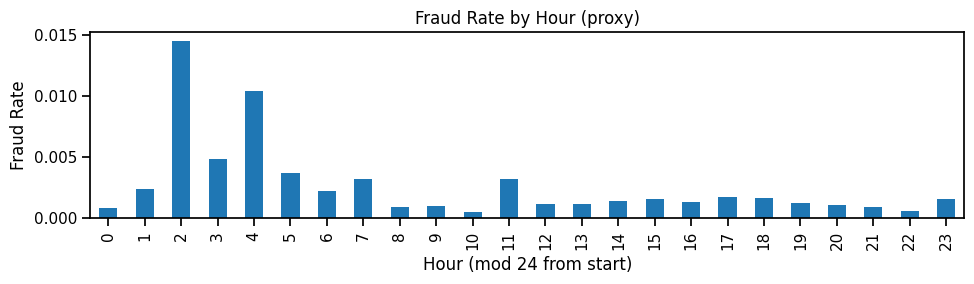

In [77]:
hour_rate = df.groupby("Hour_from_start_mod24")["Class"].mean().reindex(range(24)).fillna(0)
hour_rate.plot(kind="bar", figsize=(10,3), title="Fraud Rate by Hour (proxy)")
plt.xlabel("Hour (mod 24 from start)"); plt.ylabel("Fraud Rate")
plt.tight_layout(); plt.show()


## Barplot Fraud vs Normal

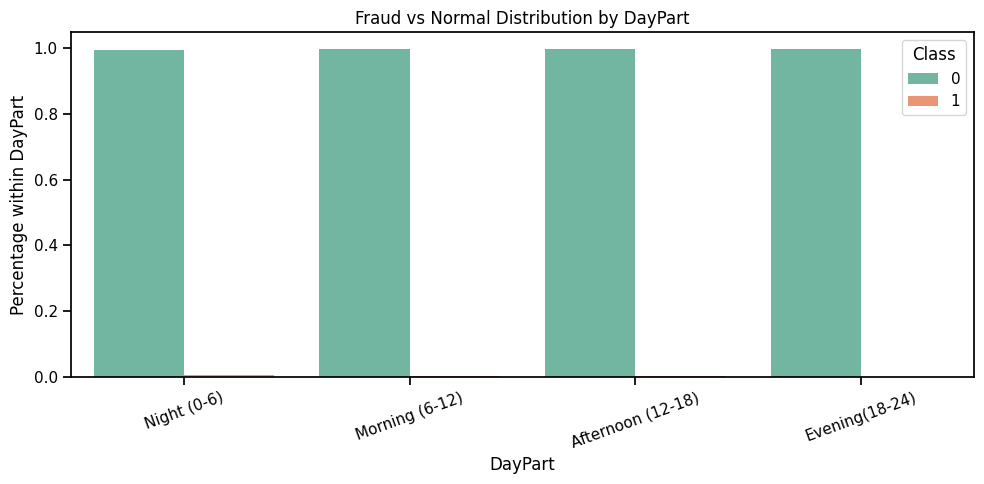

In [78]:
day_counts = df.groupby(["DayPart","Class"]).size().reset_index(name="Count")
day_total  = day_counts.groupby("DayPart")["Count"].transform("sum")
day_counts["Pct"] = day_counts["Count"] / day_total

sns.barplot(x="DayPart", y="Pct", hue="Class", data=day_counts, palette="Set2")
plt.title("Fraud vs Normal Distribution by DayPart")
plt.ylabel("Percentage within DayPart")
plt.xticks(rotation=20)
plt.tight_layout()
plt.show()


## Cumulative share of fraud by Amount rank


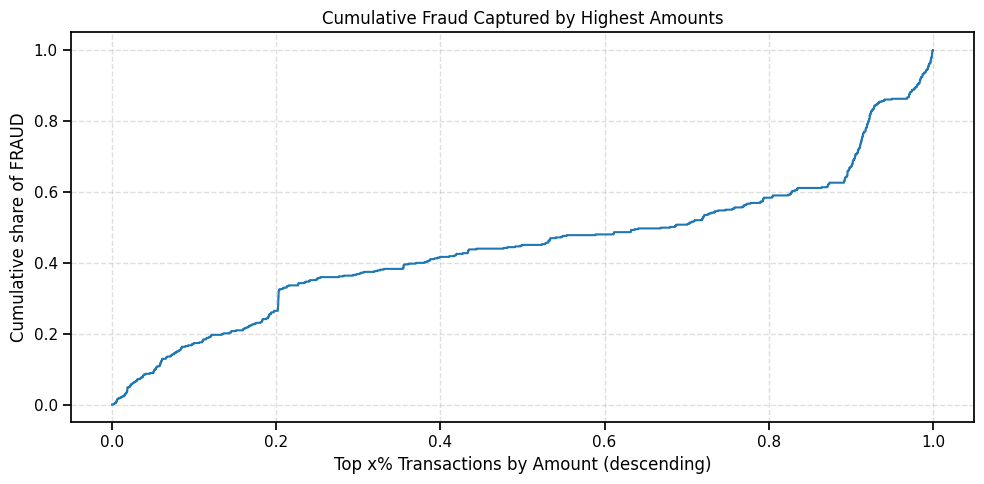

In [79]:
tmp = df[["Amount","Class"]].sort_values("Amount", ascending=False).reset_index(drop=True)
tmp["cum_tx"] = np.arange(1, len(tmp)+1) / len(tmp)
tmp["cum_fraud"] = tmp["Class"].cumsum() / tmp["Class"].sum()

plt.plot(tmp["cum_tx"], tmp["cum_fraud"])
plt.xlabel("Top x% Transactions by Amount (descending)")
plt.ylabel("Cumulative share of FRAUD")
plt.title("Cumulative Fraud Captured by Highest Amounts")
plt.grid(True, ls="--", alpha=0.4)
plt.tight_layout()
plt.show()


## Time-based Split (no look-ahead leakage)

In [80]:
df_sorted = df.sort_values("Time").reset_index(drop=True)
cut = int(0.8 * len(df_sorted))
train_df, test_df = df_sorted.iloc[:cut], df_sorted.iloc[cut:]

# Inner validation from train (time-ordered)
cut_in = int(0.8 * len(train_df))
train__df, val_df = train_df.iloc[:cut_in], train_df.iloc[cut_in:]

X_train , y_train = train__df[features], train__df[target].astype(int)
X_val   , y_val   = val_df[features]  , val_df[target].astype(int)
X_test  , y_test  = test_df[features] , test_df[target].astype(int)

print("Inner-Train:", len(X_train), "| Val:", len(X_val), "| Test:", len(X_test))
print("Train prevalence:", y_train.mean(), "| Test prevalence:", y_test.mean())


Inner-Train: 181584 | Val: 45396 | Test: 56746
Train prevalence: 0.001910961318177813 | Test prevalence: 0.0013040566735981391


# Utilities: Metrics, Thresholds, Cost

In [81]:
def evaluate_block(y_true, y_score, thr=0.5):
    y_pred = (y_score >= thr).astype(int)
    tn, fp, fn, tp = confusion_matrix(y_true, y_pred, labels=[0,1]).ravel()
    return dict(
        threshold=float(thr),
        precision=precision_score(y_true, y_pred, zero_division=0),
        recall=recall_score(y_true, y_pred),
        f1=f1_score(y_true, y_pred, zero_division=0),
        roc_auc=roc_auc_score(y_true, y_score),
        auprc=average_precision_score(y_true, y_score),
        brier=brier_score_loss(y_true, y_score),
        tp=int(tp), fp=int(fp), fn=int(fn), tn=int(tn)
    )

def thr_for_precision(y_true, y_score, target_p=0.90):
    ps, rs, ths = precision_recall_curve(y_true, y_score)
    hits = np.where(ps[:-1] >= target_p)[0]
    if hits.size:
        i = hits[0]
        return float(ths[i]), float(ps[i]), float(rs[i])
    i = np.argmax(0.5*ps[:-1] + 0.5*rs[:-1])  
    return float(ths[i]), float(ps[i]), float(rs[i])


def thr_min_cost(y_true , y_score , cost_fp=COST_FP , cost_fn=COST_FN, grid=1001):
    best_thr , best_cost = 0.5, float("inf")
    for t in np.linspace(0,1, grid):
        yhat = (y_score >= t).astype(int)
        tn, fp, fn, tp = confusion_matrix(y_true ,yhat, labels=[0,1]).ravel()
        cost = fp*cost_fp + fn*cost_fn
        if cost < best_cost:
            best_thr , best_cost = float(t), float(cost)
    return best_thr , best_cost

def realized_cost(y_true, y_score, thr, cost_fp=COST_FP, cost_fn=COST_FN):
    yhat = (y_score >= thr).astype(int)
    tn, fp, fn, tp = confusion_matrix(y_true, yhat, labels=[0,1]).ravel()
    return fp*cost_fp + fn*cost_fn

def plot_pr_roc(y_true, y_score ,title):
    ps,rs , _ = precision_recall_curve(y_true , y_score)
    plt.plot(rs, ps)
    plt.axhline(y_true.mean(), ls="--", alpha=0.5)
    plt.xlabel("Recall"); plt.ylabel("Precision")
    plt.title(f"{title} — PR (AP={average_precision_score(y_true,y_score):.3f})")
    plt.grid(True, ls="--", alpha=0.4); plt.tight_layout(); plt.show()
    fpr, tpr, _ = roc_curve(y_true, y_score)
    plt.plot(fpr, tpr)
    plt.xlabel("FPR"); plt.ylabel("TPR")
    plt.title(f"{title} — ROC (AUC={roc_auc_score(y_true,y_score):.3f})")
    plt.grid(True, ls="--", alpha=0.4); plt.tight_layout(); plt.show()

def reliability_plot(y_true, y_score, title, bins=10):
    prob_true, prob_pred = calibration_curve(y_true, y_score, n_bins=bins, strategy="quantile")
    plt.plot(prob_pred, prob_true, marker="o")
    plt.plot([0,1],[0,1], "--", alpha=0.6)
    plt.xlabel("Predicted probability"); plt.ylabel("Empirical probability")
    plt.title(title + f" — Brier={brier_score_loss(y_true, y_score):.4f}")
    plt.grid(True, ls="--", alpha=0.4); plt.tight_layout(); plt.show()
    
def expected_calibration_error(y_true, y_prob, n_bins=15):
    """
    Simple (non-standardized) ECE: weighted avg |acc - conf| over quantized bins.
    For formal comparisons, prefer standardized definitions.
    """
    bins = np.linspace(0.0, 1.0, n_bins+1)
    idx = np.digitize(y_prob, bins) - 1
    ece = 0.0
    for b in range(n_bins):
        mask = (idx == b)
        if not np.any(mask):
            continue
        conf = y_prob[mask].mean()
        acc  = y_true[mask].mean()
        ece += (mask.mean()) * abs(acc - conf)
    return float(ece)

rng = np.random.default_rng(SEED)
def bootstrap_ci(metric_fn, y_true, y_score, B=300, alpha=0.05):
    n = len(y_true)
    vals = []
    for _ in range(B):
        idx = rng.integers(0, n, size=n)
        vals.append(metric_fn(y_true[idx], y_score[idx]))
    lo = np.quantile(vals, alpha/2)
    hi = np.quantile(vals, 1 - alpha/2)
    return float(lo), float(hi)


def sweep_thresholds(y_true, y_prob, costs=(COST_FP, COST_FN)):
    ths = np.linspace(0, 1, 101)
    rows = []
    for t in ths:
        yhat = (y_prob >= t).astype(int)
        tn, fp, fn, tp = confusion_matrix(y_true, yhat, labels=[0,1]).ravel()
        prec = precision_score(y_true, yhat, zero_division=0)
        rec  = recall_score(y_true, yhat)
        f1   = f1_score(y_true, yhat, zero_division=0)
        cost = fp*costs[0] + fn*costs[1]
        rows.append([t, prec, rec, f1, tp, fp, fn, tn, cost])
    return pd.DataFrame(rows, columns=["thr","precision","recall","f1","tp","fp","fn","tn","cost"])

def plot_alerts_and_savings(df_sweep, title):
    fig, ax = plt.subplots(1,2, figsize=(12,4))
    # Alerts = predicted positives = tp+fp
    ax[0].plot(df_sweep["thr"], df_sweep["tp"]+df_sweep["fp"])
    ax[0].set_title(title+" — Alerts vs Threshold"); ax[0].set_xlabel("Threshold"); ax[0].set_ylabel("#Alerts")
    # Savings = (tp * FN_cost) - (fp * FP_cost)
    savings = df_sweep["tp"]*COST_FN - df_sweep["fp"]*COST_FP
    ax[1].plot(df_sweep["thr"], savings)
    ax[1].set_title(title+" — Net Savings vs Threshold"); ax[1].set_xlabel("Threshold"); ax[1].set_ylabel("Net Savings ($)")
    plt.tight_layout(); plt.show()


## Baseline Logistic + RF

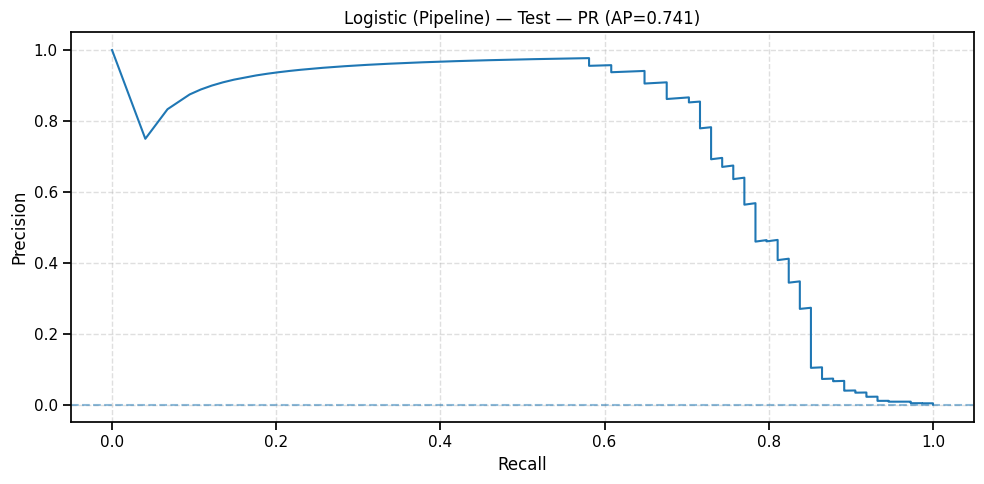

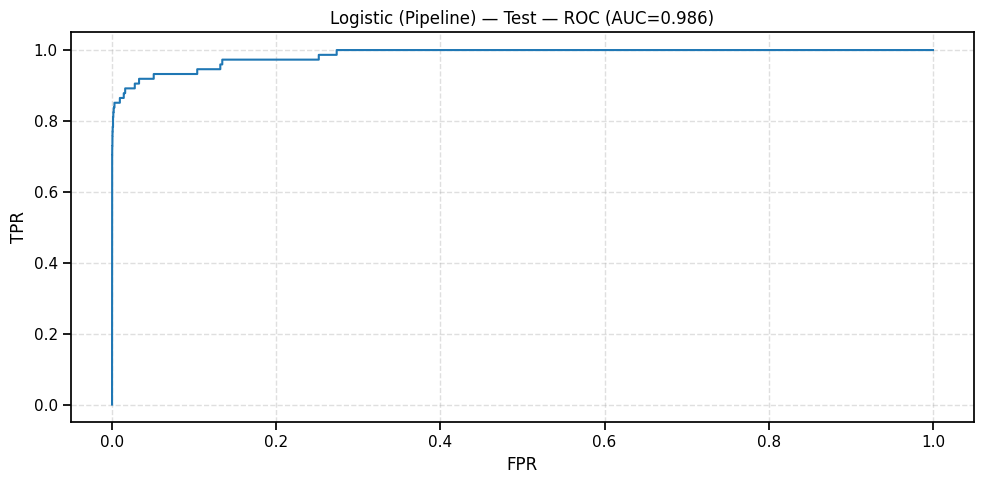

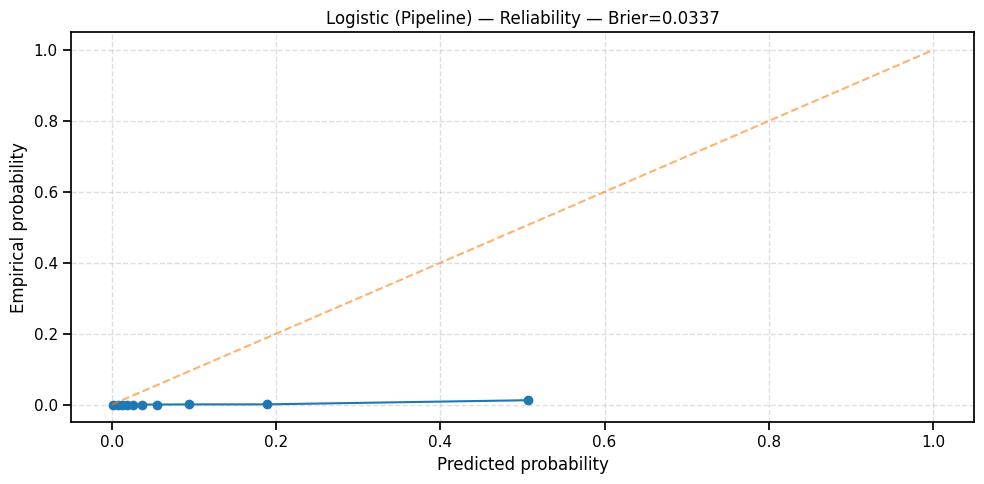

[Logistic|Pipeline] VAL AUPRC: 0.7749693650102897
[Logistic|Pipeline] TEST AUPRC: 0.7414676125025982


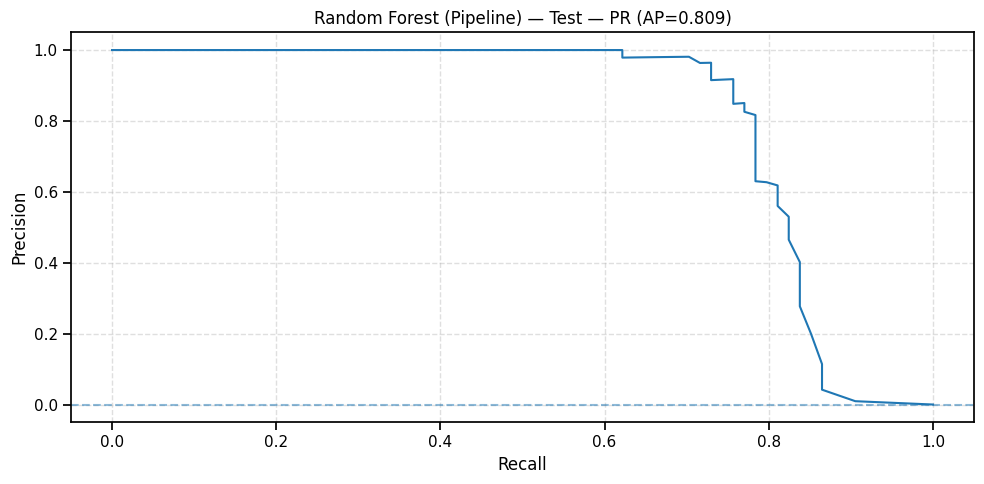

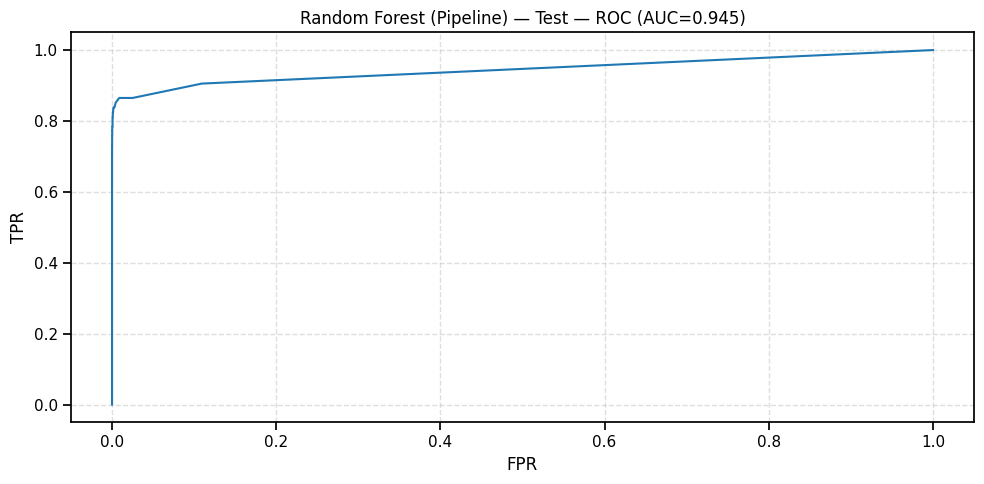

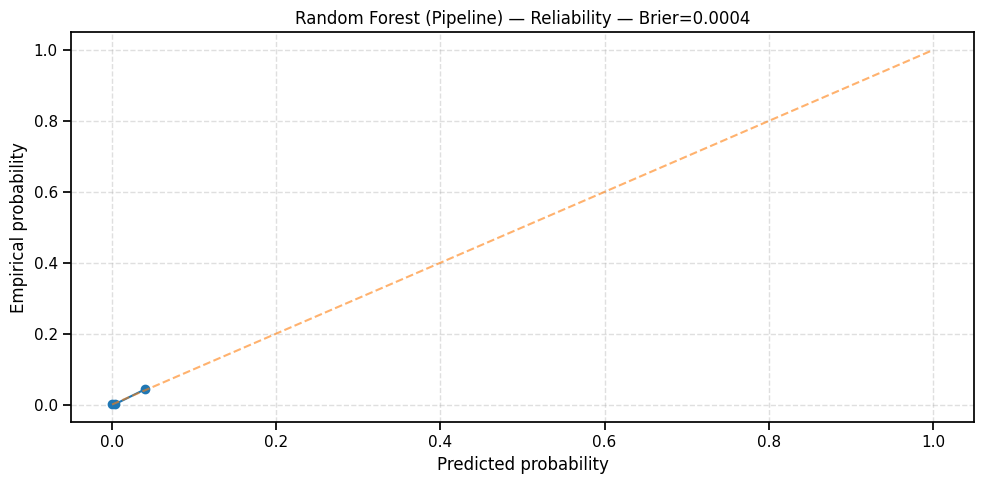

[RF|Pipeline] VAL AUPRC: 0.7590832276209166
[RF|Pipeline] TEST AUPRC: 0.8087618841310673


In [82]:
# Logistic Regression 
logit_pipe = ImbPipeline(steps=[
    ("scaler", StandardScaler(with_mean=True)),
    ("clf", LogisticRegression(max_iter=2000, class_weight="balanced", random_state=SEED))
])
logit_pipe.fit(X_train, y_train)

val_log_proba  = logit_pipe.predict_proba(X_val)[:, 1]
test_log_proba = logit_pipe.predict_proba(X_test)[:, 1]


plot_pr_roc(y_test, test_log_proba, "Logistic (Pipeline) — Test")
reliability_plot(y_test, test_log_proba, "Logistic (Pipeline) — Reliability")
print("[Logistic|Pipeline] VAL AUPRC:",  average_precision_score(y_val , val_log_proba))
print("[Logistic|Pipeline] TEST AUPRC:", average_precision_score(y_test, test_log_proba))

# Random Forest
rf_pipe = ImbPipeline(steps=[
    ("clf", RandomForestClassifier(
        n_estimators=300,
        class_weight="balanced",
        random_state=SEED,
        n_jobs=-1
    ))
])
rf_pipe.fit(X_train, y_train)

val_rf_proba  = rf_pipe.predict_proba(X_val)[:, 1]
test_rf_proba = rf_pipe.predict_proba(X_test)[:, 1]


plot_pr_roc(y_test, test_rf_proba, "Random Forest (Pipeline) — Test")
reliability_plot(y_test, test_rf_proba, "Random Forest (Pipeline) — Reliability")
print("[RF|Pipeline] VAL AUPRC:",  average_precision_score(y_val , val_rf_proba))
print("[RF|Pipeline] TEST AUPRC:", average_precision_score(y_test, test_rf_proba))


##  Strong Model — XGBoost 

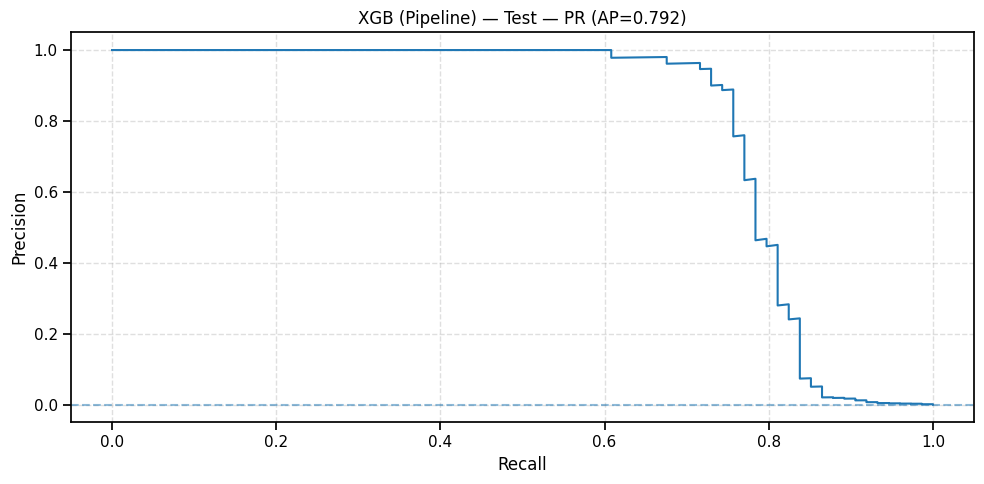

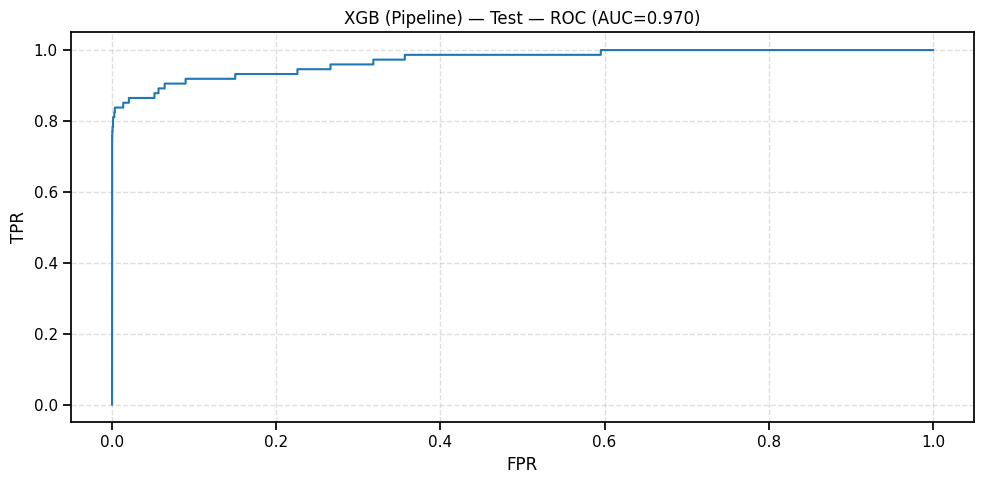

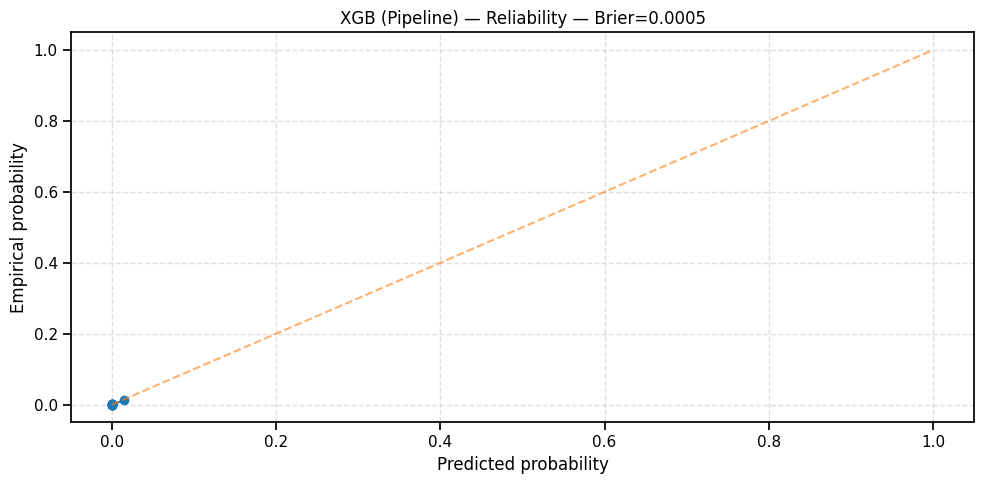

[XGB|Pipeline] VAL AUPRC: 0.7804945734108562
[XGB|Pipeline] TEST AUPRC: 0.7918641555213096


In [83]:
pos, neg = int((y_train==1).sum()), int((y_train==0).sum())
spw = neg / max(1, pos)  # scale_pos_weight ≈ imbalance ratio

xgb_pipe = ImbPipeline(steps=[
    ("model", XGBClassifier(
        n_estimators=600, max_depth=4, learning_rate=0.05,
        subsample=0.9, colsample_bytree=0.9, reg_lambda=1.0,
        tree_method="hist", random_state=SEED,
        scale_pos_weight=spw, n_jobs=-1, eval_metric="aucpr"
    ))
])
xgb_pipe.fit(X_train, y_train)

val_xgb_proba  = xgb_pipe.predict_proba(X_val)[:, 1]
test_xgb_proba = xgb_pipe.predict_proba(X_test)[:, 1]

plot_pr_roc(y_test, test_xgb_proba, "XGB (Pipeline) — Test")
reliability_plot(y_test, test_xgb_proba, "XGB (Pipeline) — Reliability")
print("[XGB|Pipeline] VAL AUPRC:",  average_precision_score(y_val, val_xgb_proba))
print("[XGB|Pipeline] TEST AUPRC:", average_precision_score(y_test, test_xgb_proba))


# Calibration (Isotonic) with TimeSeriesSplit on TRAIN

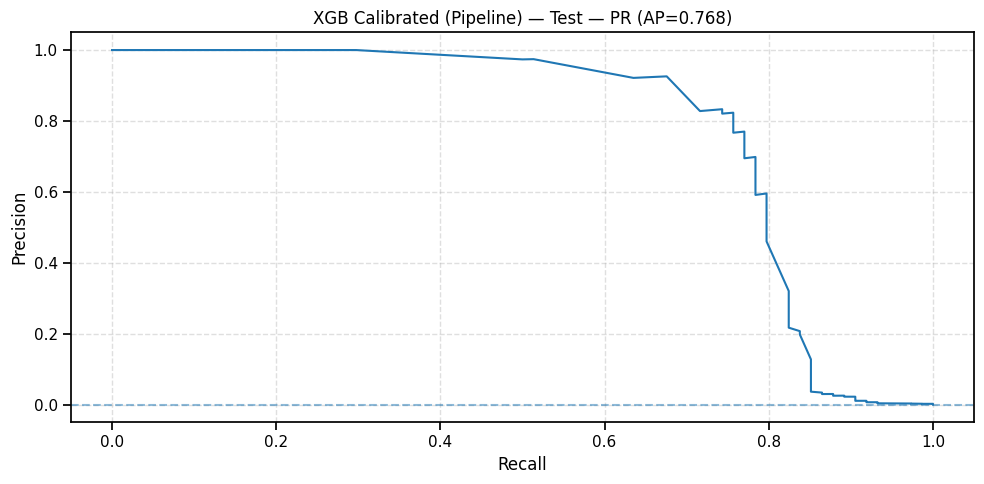

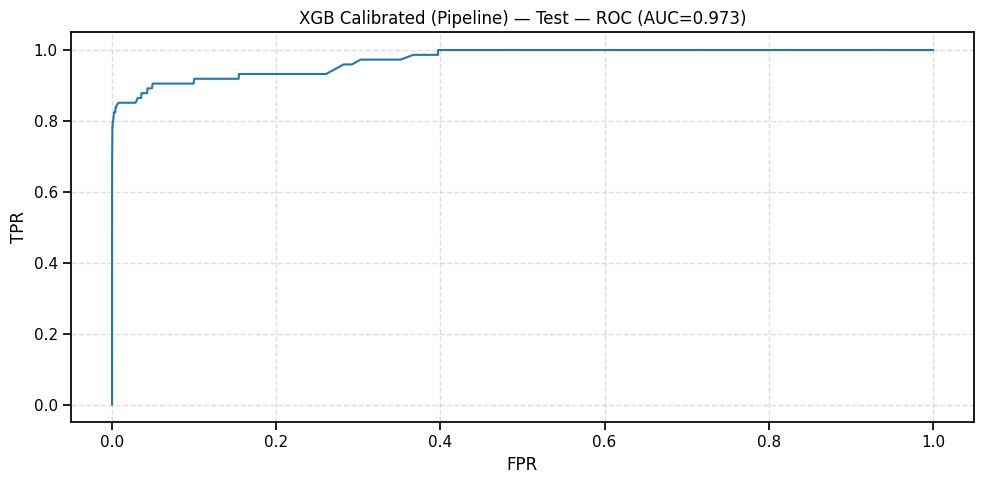

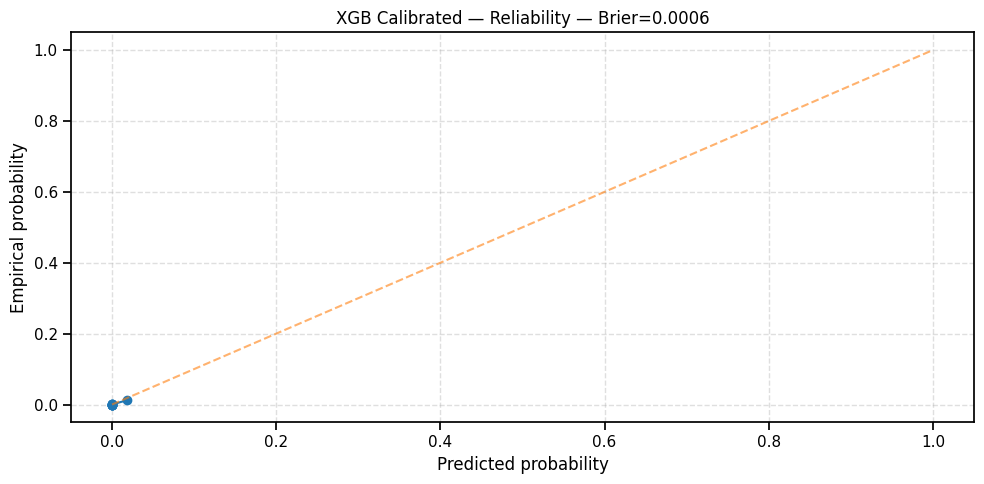

[XGB-Cal|Pipeline] VAL AUPRC: 0.7380365956739079
[XGB-Cal|Pipeline] TEST AUPRC: 0.7678117555792706
ECE[Test] XGB-Cal: 0.0006898826800415963


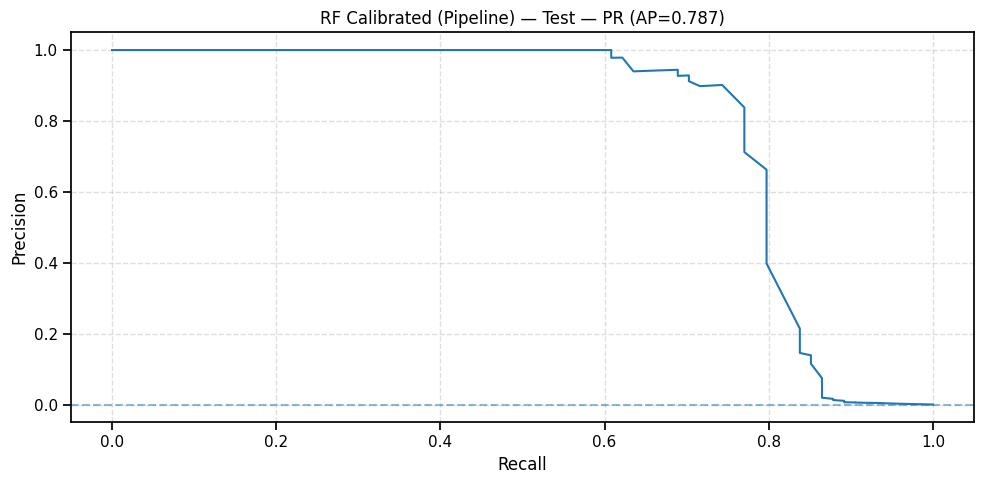

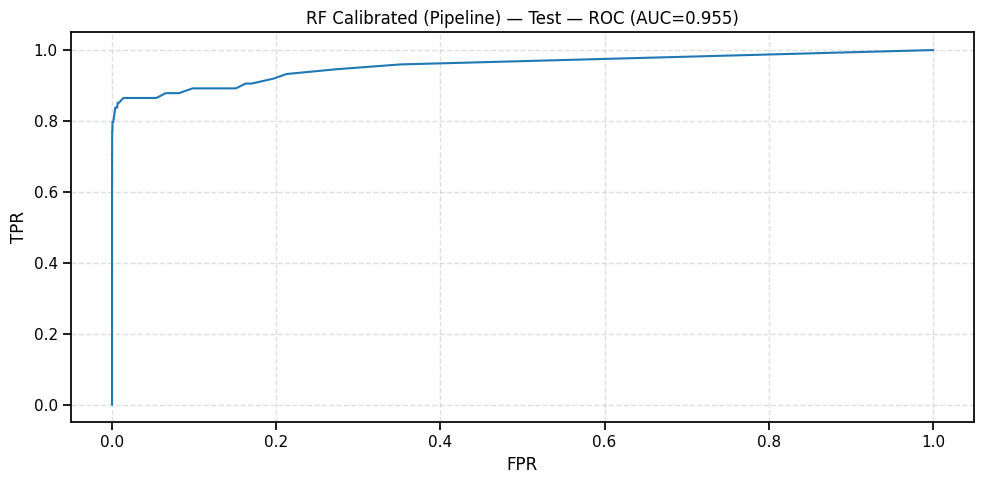

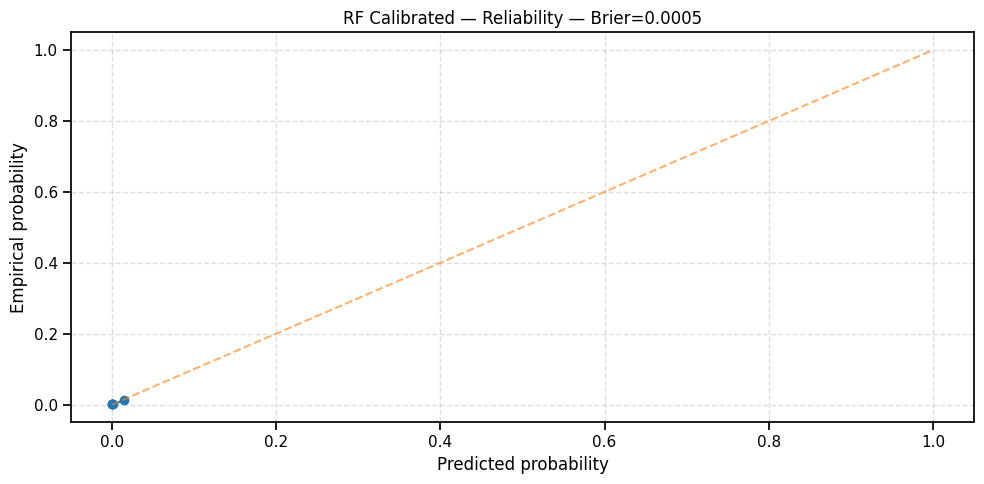

[RF-Cal] VAL AUPRC: 0.7429412238400823
[RF-Cal] TEST AUPRC: 0.7870914598203886
ECE[Test] RF-Cal : 0.00042467636259168733


In [84]:
cal_cv = TimeSeriesSplit(n_splits=3)

# Calibrated XGB
xgb_cal = CalibratedClassifierCV(estimator=xgb_pipe, method="isotonic", cv=cal_cv)
xgb_cal.fit(X_train, y_train)
val_xgb_cal  = xgb_cal.predict_proba(X_val)[:, 1]
test_xgb_cal = xgb_cal.predict_proba(X_test)[:, 1]

plot_pr_roc(y_test, test_xgb_cal, "XGB Calibrated (Pipeline) — Test")
reliability_plot(y_test, test_xgb_cal, "XGB Calibrated — Reliability")
print("[XGB-Cal|Pipeline] VAL AUPRC:",  average_precision_score(y_val, val_xgb_cal))
print("[XGB-Cal|Pipeline] TEST AUPRC:", average_precision_score(y_test, test_xgb_cal))
print("ECE[Test] XGB-Cal:", expected_calibration_error(y_test.values, test_xgb_cal, n_bins=15))


# Calibrated RF
rf_cal = CalibratedClassifierCV(estimator=rf_pipe, method="isotonic", cv=cal_cv)
rf_cal.fit(X_train, y_train)
val_rf_cal  = rf_cal.predict_proba(X_val)[:, 1]
test_rf_cal = rf_cal.predict_proba(X_test)[:, 1]

plot_pr_roc(y_test, test_rf_cal, "RF Calibrated (Pipeline) — Test")
reliability_plot(y_test, test_rf_cal, "RF Calibrated — Reliability")
print("[RF-Cal] VAL AUPRC:",  average_precision_score(y_val,  val_rf_cal))
print("[RF-Cal] TEST AUPRC:", average_precision_score(y_test, test_rf_cal))
print("ECE[Test] RF-Cal :", expected_calibration_error(y_test.values, test_rf_cal,  n_bins=15))




# Overlay PR Curves

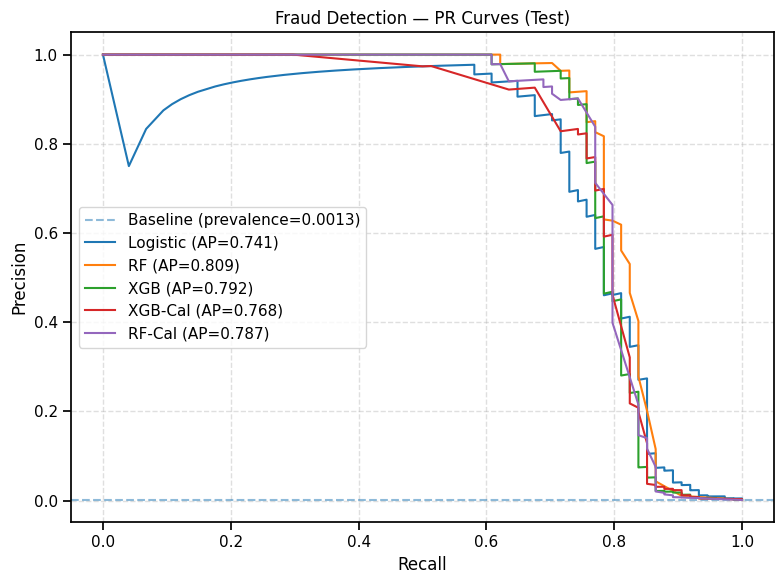

In [85]:

def plot_pr_overlay(y_true, preds_dict, title="PR Curves — Overlay"):
    plt.figure(figsize=(8,6))
    base = y_true.mean()
    plt.axhline(base, ls="--", alpha=0.5, label=f"Baseline (prevalence={base:.4f})")
    
    for name, y_prob in preds_dict.items():
        ps, rs, _ = precision_recall_curve(y_true, y_prob)
        ap = average_precision_score(y_true, y_prob)
        plt.plot(rs, ps, label=f"{name} (AP={ap:.3f})")
    
    plt.xlabel("Recall")
    plt.ylabel("Precision")
    plt.title(title)
    plt.grid(True, ls="--", alpha=0.4)
    plt.legend()
    plt.tight_layout()
    plt.show()

preds_test = {
    "Logistic":        test_log_proba,
    "RF":              test_rf_proba,
    "XGB":             test_xgb_proba,
    "XGB-Cal":         test_xgb_cal,
        "RF-Cal":          test_rf_cal,
}
plot_pr_overlay(y_test, preds_test, title="Fraud Detection — PR Curves (Test)")


# Reliability Overlay for key models

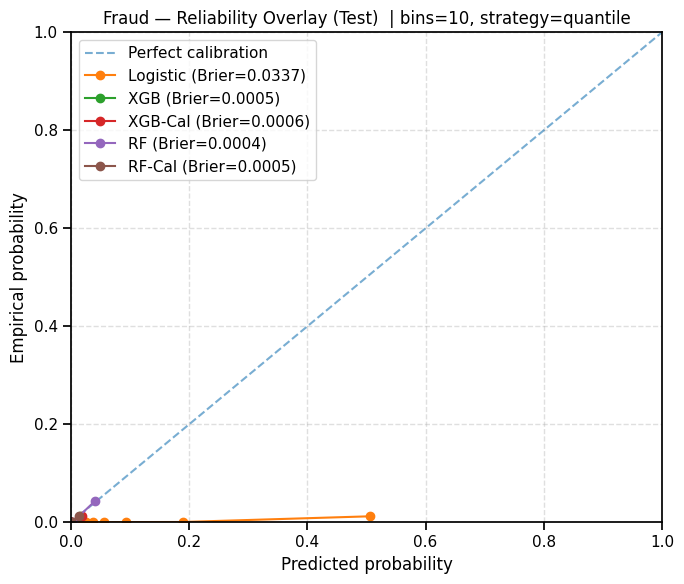

In [86]:
def reliability_overlay(y_true, preds_dict, bins=10, strategy="quantile",
                        title="Reliability (Calibration) — Overlay"):
    plt.figure(figsize=(7,6))
    plt.plot([0,1],[0,1], "--", alpha=0.6, label="Perfect calibration")

    for name, y_prob in preds_dict.items():
        prob_true, prob_pred = calibration_curve(y_true, y_prob,
                                                n_bins=bins, strategy=strategy)
        brier = brier_score_loss(y_true, y_prob)
        plt.plot(prob_pred, prob_true, marker="o", label=f"{name} (Brier={brier:.4f})")

    plt.xlim(0, 1); plt.ylim(0, 1)  
    plt.xlabel("Predicted probability")
    plt.ylabel("Empirical probability")
    plt.title(title + f"  | bins={bins}, strategy={strategy}")
    plt.grid(True, ls="--", alpha=0.4)
    plt.legend()
    plt.tight_layout()
    plt.show()

reliab_models = {
    "Logistic": test_log_proba,
    "XGB":      test_xgb_proba,
    "XGB-Cal":  test_xgb_cal,
    "RF":       test_rf_proba,
    "RF-Cal":   test_rf_cal,
}
reliability_overlay(y_test, reliab_models, bins=10, strategy="quantile",
                    title="Fraud — Reliability Overlay (Test)")


# Threshold Tuning XGB-Cal

[VAL|XGB-Cal] Thr@P≥90%: thr=0.949, P=0.963, R=0.500
[VAL|XGB-Cal] Thr@Min-Cost: thr=0.137, Cost=2315.00

===== XGB-Cal — TEST EVAL =====
XGB-Cal@Test (Thr@P≥90%): {'threshold': 0.9486419757207235, 'precision': np.float64(0.9736842105263158), 'recall': np.float64(0.5), 'f1': np.float64(0.6607142857142857), 'roc_auc': np.float64(0.9726398564713782), 'auprc': np.float64(0.7678117555792706), 'brier': np.float64(0.0005720536158670537), 'tp': 37, 'fp': 1, 'fn': 37, 'tn': 56671}
XGB-Cal@Test (Thr@Min-Cost): {'threshold': 0.137, 'precision': np.float64(0.4796747967479675), 'recall': np.float64(0.7972972972972973), 'f1': np.float64(0.5989847715736041), 'roc_auc': np.float64(0.9726398564713782), 'auprc': np.float64(0.7678117555792706), 'brier': np.float64(0.0005720536158670537), 'tp': 59, 'fp': 64, 'fn': 15, 'tn': 56608}
[TEST|XGB-Cal] Realized Cost @ P≥90% thr (0.949): 7405.00
[TEST|XGB-Cal] Realized Cost @ Min-Cost thr (0.137): 3320.00


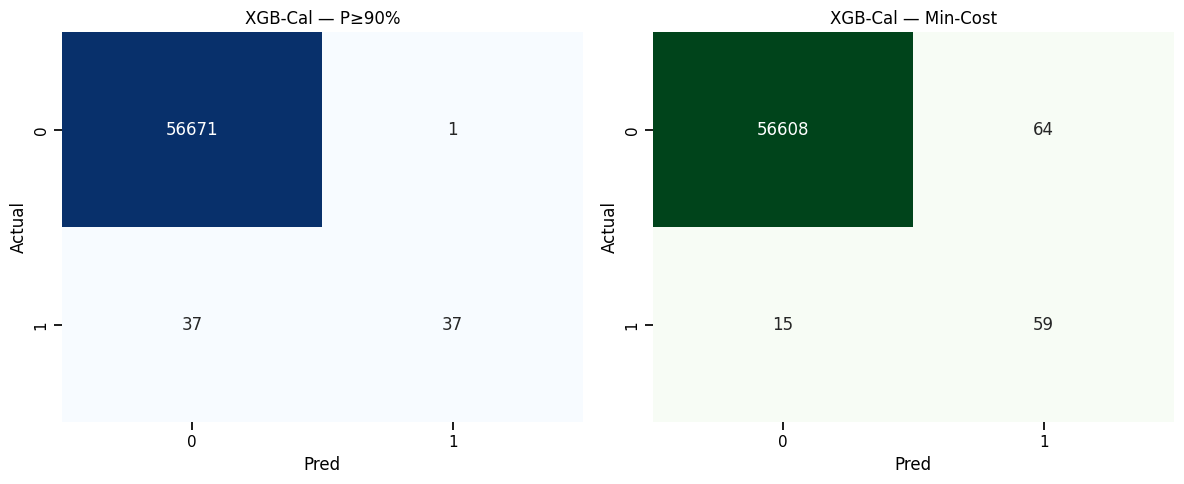

In [87]:
thr_p90_xgb, p_val_xgb, r_val_xgb = thr_for_precision(y_val, val_xgb_cal, target_p=0.90)
thr_cost_xgb, best_cost_val_xgb = thr_min_cost(y_val,  val_xgb_cal, cost_fp=COST_FP, cost_fn=COST_FN)

print(f"[VAL|XGB-Cal] Thr@P≥90%: thr={thr_p90_xgb:.3f}, P={p_val_xgb:.3f}, R={r_val_xgb:.3f}")
print(f"[VAL|XGB-Cal] Thr@Min-Cost: thr={thr_cost_xgb:.3f}, Cost={best_cost_val_xgb:.2f}")

eval_xgb_p90  = evaluate_block(y_test, test_xgb_cal, thr_p90_xgb)
eval_xgb_cost = evaluate_block(y_test, test_xgb_cal, thr_cost_xgb)
cm_xgb_p90  = confusion_matrix(y_test, (test_xgb_cal >= thr_p90_xgb ).astype(int))
cm_xgb_cost = confusion_matrix(y_test, (test_xgb_cal >= thr_cost_xgb).astype(int))

print("\n===== XGB-Cal — TEST EVAL =====")
print("XGB-Cal@Test (Thr@P≥90%):",  eval_xgb_p90)
print("XGB-Cal@Test (Thr@Min-Cost):", eval_xgb_cost)

cost_xgb_p90 = realized_cost(y_test, test_xgb_cal, thr_p90_xgb,  cost_fp=COST_FP, cost_fn=COST_FN)
cost_xgb_min = realized_cost(y_test, test_xgb_cal, thr_cost_xgb, cost_fp=COST_FP, cost_fn=COST_FN)
print(f"[TEST|XGB-Cal] Realized Cost @ P≥90% thr ({thr_p90_xgb:.3f}): {cost_xgb_p90:.2f}")
print(f"[TEST|XGB-Cal] Realized Cost @ Min-Cost thr ({thr_cost_xgb:.3f}): {cost_xgb_min:.2f}")

fig, axes = plt.subplots(1, 2, figsize=(12,5))
sns.heatmap(cm_xgb_p90,  annot=True, fmt='d', cmap='Blues', cbar=False, ax=axes[0])
axes[0].set_title('XGB-Cal — P≥90%');  axes[0].set_xlabel('Pred'); axes[0].set_ylabel('Actual')
sns.heatmap(cm_xgb_cost, annot=True, fmt='d', cmap='Greens', cbar=False, ax=axes[1])
axes[1].set_title('XGB-Cal — Min-Cost'); axes[1].set_xlabel('Pred'); axes[1].set_ylabel('Actual')
plt.tight_layout(); plt.show()


# Threshold tuning RF-Cal



[VAL|RF-Cal] Thr@P≥90%: thr=0.712, P=0.902, R=0.712
[VAL|RF-Cal] Thr@Min-Cost: thr=0.051, Cost=2260.00

===== RF-Cal — TEST EVAL =====
RF-Cal@Test (Thr@P≥90%): {'threshold': 0.712121212121212, 'precision': np.float64(0.8983050847457628), 'recall': np.float64(0.7162162162162162), 'f1': np.float64(0.7969924812030075), 'roc_auc': np.float64(0.955351062348345), 'auprc': np.float64(0.7870914598203886), 'brier': np.float64(0.00045009662595362984), 'tp': 53, 'fp': 6, 'fn': 21, 'tn': 56666}
RF-Cal@Test (Thr@Min-Cost): {'threshold': 0.051000000000000004, 'precision': np.float64(0.4645669291338583), 'recall': np.float64(0.7972972972972973), 'f1': np.float64(0.5870646766169154), 'roc_auc': np.float64(0.955351062348345), 'auprc': np.float64(0.7870914598203886), 'brier': np.float64(0.00045009662595362984), 'tp': 59, 'fp': 68, 'fn': 15, 'tn': 56604}
[TEST|RF-Cal] Realized Cost @ P≥90% thr (0.712): 4230.00
[TEST|RF-Cal] Realized Cost @ Min-Cost thr (0.051): 3340.00


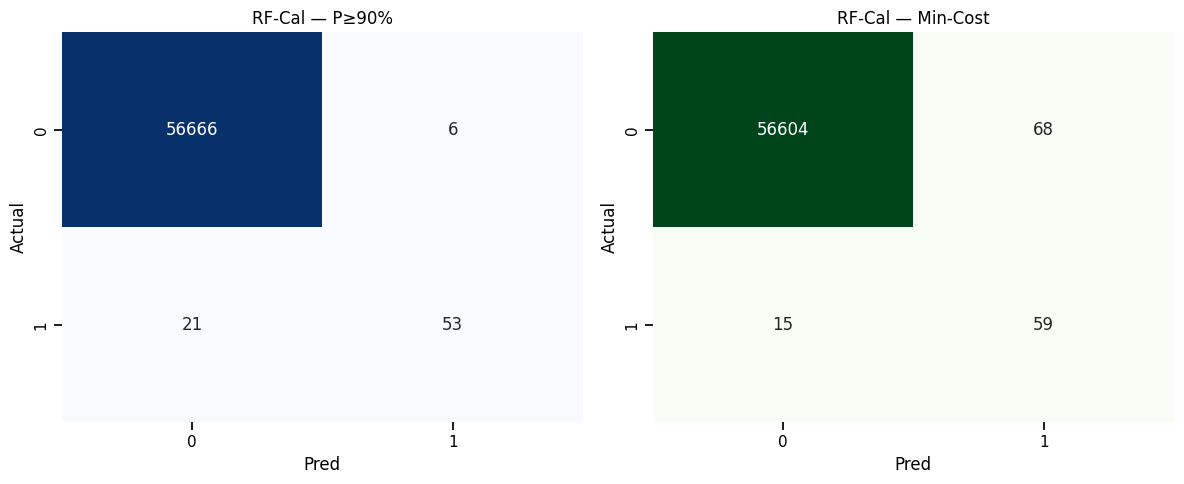

In [88]:
thr_p90_rf, p_val_rf, r_val_rf = thr_for_precision(y_val, val_rf_cal, target_p=0.90)
thr_cost_rf, best_cost_val_rf = thr_min_cost(y_val,  val_rf_cal, cost_fp=COST_FP, cost_fn=COST_FN)

print(f"\n[VAL|RF-Cal] Thr@P≥90%: thr={thr_p90_rf:.3f}, P={p_val_rf:.3f}, R={r_val_rf:.3f}")
print(f"[VAL|RF-Cal] Thr@Min-Cost: thr={thr_cost_rf:.3f}, Cost={best_cost_val_rf:.2f}")

eval_rf_p90  = evaluate_block(y_test, test_rf_cal, thr_p90_rf)
eval_rf_cost = evaluate_block(y_test, test_rf_cal, thr_cost_rf)
cm_rf_p90  = confusion_matrix(y_test, (test_rf_cal >= thr_p90_rf ).astype(int))
cm_rf_cost = confusion_matrix(y_test, (test_rf_cal >= thr_cost_rf).astype(int))

print("\n===== RF-Cal — TEST EVAL =====")
print("RF-Cal@Test (Thr@P≥90%):",  eval_rf_p90)
print("RF-Cal@Test (Thr@Min-Cost):", eval_rf_cost)

cost_rf_p90 = realized_cost(y_test, test_rf_cal, thr_p90_rf,  cost_fp=COST_FP, cost_fn=COST_FN)
cost_rf_min = realized_cost(y_test, test_rf_cal, thr_cost_rf, cost_fp=COST_FP, cost_fn=COST_FN)
print(f"[TEST|RF-Cal] Realized Cost @ P≥90% thr ({thr_p90_rf:.3f}): {cost_rf_p90:.2f}")
print(f"[TEST|RF-Cal] Realized Cost @ Min-Cost thr ({thr_cost_rf:.3f}): {cost_rf_min:.2f}")

fig, axes = plt.subplots(1, 2, figsize=(12,5))
sns.heatmap(cm_rf_p90,  annot=True, fmt='d', cmap='Blues', cbar=False, ax=axes[0])
axes[0].set_title('RF-Cal — P≥90%');  axes[0].set_xlabel('Pred'); axes[0].set_ylabel('Actual')
sns.heatmap(cm_rf_cost, annot=True, fmt='d', cmap='Greens', cbar=False, ax=axes[1])
axes[1].set_title('RF-Cal — Min-Cost'); axes[1].set_xlabel('Pred'); axes[1].set_ylabel('Actual')
plt.tight_layout(); plt.show()


#  Cost & Alerts vs Threshold

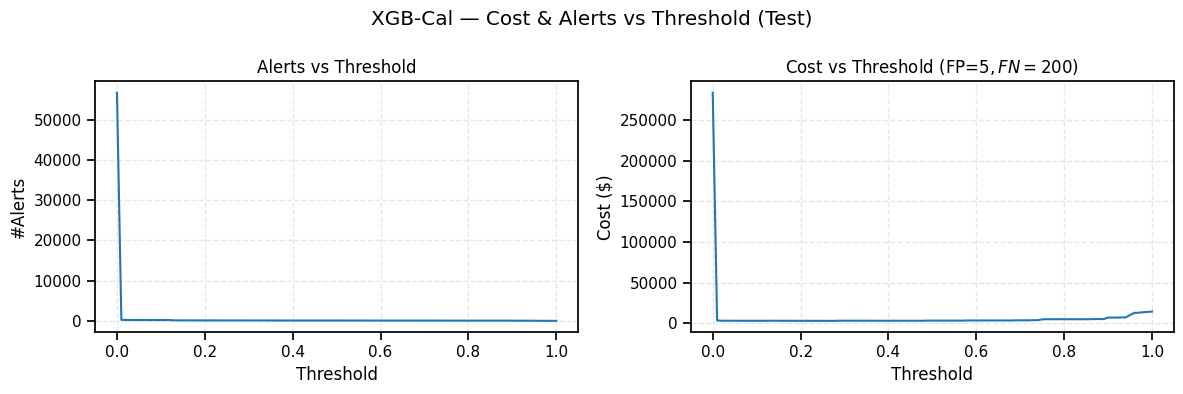

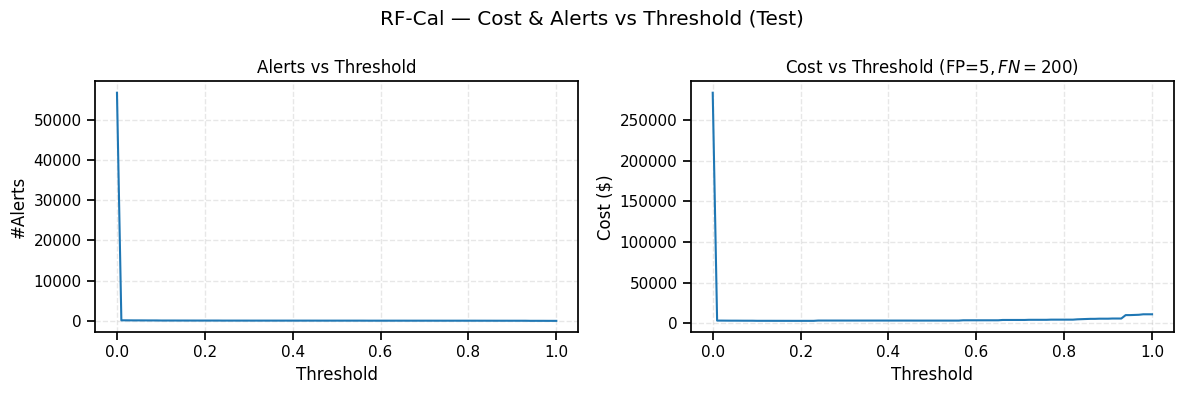

In [89]:
def plot_cost_and_alerts(y_true, y_prob, cost_fp=5.0, cost_fn=200.0, title="Cost & Alerts vs Threshold"):
    df_sweep = sweep_thresholds(y_true, y_prob, costs=(cost_fp, cost_fn))
    fig, ax = plt.subplots(1,2, figsize=(12,4))
    # Alerts = tp + fp
    ax[0].plot(df_sweep["thr"], df_sweep["tp"] + df_sweep["fp"])
    ax[0].set_title("Alerts vs Threshold")
    ax[0].set_xlabel("Threshold"); ax[0].set_ylabel("#Alerts")
    ax[0].grid(True, ls="--", alpha=0.3)

    # Cost curve
    ax[1].plot(df_sweep["thr"], df_sweep["cost"])
    ax[1].set_title(f"Cost vs Threshold (FP=${cost_fp:.0f}, FN=${cost_fn:.0f})")
    ax[1].set_xlabel("Threshold"); ax[1].set_ylabel("Cost ($)")
    ax[1].grid(True, ls="--", alpha=0.3)

    plt.suptitle(title)
    plt.tight_layout()
    plt.show()
    return df_sweep

df_xgbcal_sweep = plot_cost_and_alerts(y_test, test_xgb_cal, cost_fp=COST_FP, cost_fn=COST_FN,
                                      title="XGB-Cal — Cost & Alerts vs Threshold (Test)")
df_rfcal_sweep  = plot_cost_and_alerts(y_test, test_rf_cal,  cost_fp=COST_FP, cost_fn=COST_FN,
                                      title="RF-Cal — Cost & Alerts vs Threshold (Test)")


## Calibrated Models — Side-by-Side

In [90]:
def summarise_model(name, y_true, y_prob, thr_p90, thr_cost):
    ap = average_precision_score(y_true, y_prob)
    roc = roc_auc_score(y_true, y_prob)
    brier = brier_score_loss(y_true, y_prob)
    ece = expected_calibration_error(y_true.values, y_prob, n_bins=15)
    cost_p90 = realized_cost(y_true, y_prob, thr_p90, COST_FP, COST_FN)
    cost_min = realized_cost(y_true, y_prob, thr_cost, COST_FP, COST_FN)
    ap_lo, ap_hi = bootstrap_ci(average_precision_score, y_true.values, y_prob)
    return {
        "Model": name, "AP(Test)": ap, "AP 95% CI": f"[{ap_lo:.3f}, {ap_hi:.3f}]",
        "ROC-AUC(Test)": roc, "Brier(Test)": brier, "ECE(15)": ece,
        "Thr@P90(val)": float(thr_p90), "Thr@MinCost(val)": float(thr_cost),
        "Cost@Test@P90": cost_p90, "Cost@Test@MinCost": cost_min,
    }

summary_df = pd.DataFrame([
    summarise_model("RF-Cal",  y_test, test_rf_cal,  thr_p90_rf,  thr_cost_rf),
    summarise_model("XGB-Cal", y_test, test_xgb_cal, thr_p90_xgb, thr_cost_xgb),
]).sort_values("AP(Test)", ascending=False)

display(summary_df.round(4))


,Model,AP(Test),AP 95% CI,ROC-AUC(Test),Brier(Test),ECE(15),Thr@P90(val),Thr@MinCost(val),Cost@Test@P90,Cost@Test@MinCost
0,RF-Cal,0.7871,"[0.692, 0.875]",0.9554,0.0005,0.0004,0.7121,0.051,4230.0,3340.0
1,XGB-Cal,0.7678,"[0.682, 0.855]",0.9726,0.0006,0.0007,0.9486,0.137,7405.0,3320.0


# Alerts and Fraud caught per 100k

In [ ]:
def summarize_ops(y_true, y_prob, thr, name, cost_fp=COST_FP, cost_fn=COST_FN):
    yhat = (y_prob >= thr).astype(int)
    tn, fp, fn, tp = confusion_matrix(y_true, yhat, labels=[0,1]).ravel()
    N = len(y_true)
    alerts = tp + fp
    cost = fp*cost_fp + fn*cost_fn
    savings = tp*cost_fn - fp*cost_fp  

    return {
        "Model": name,
        "Threshold": float(thr),
        "TP": int(tp), "FP": int(fp), "FN": int(fn), "TN": int(tn),
        "Precision": precision_score(y_true, yhat, zero_division=0),
        "Recall": recall_score(y_true, yhat),
        "F1": f1_score(y_true, yhat, zero_division=0),
        "Alerts": int(alerts),
        "Alerts/100k":  (alerts / N) * 100000,
        "FraudCaught/100k": (tp / N) * 100000,
        "Cost($)": cost,
        "Cost/100k($)": (cost / N) * 100000,
        "NetSavings($)": savings
    }

ops_rows = []
ops_rows.append(summarize_ops(y_test, test_rf_cal,  thr_p90_rf,  "RF-Cal @P90"))
ops_rows.append(summarize_ops(y_test, test_rf_cal,  thr_cost_rf, "RF-Cal @MinCost"))
ops_rows.append(summarize_ops(y_test, test_xgb_cal, thr_p90_xgb, "XGB-Cal @P90"))
ops_rows.append(summarize_ops(y_test, test_xgb_cal, thr_cost_xgb,"XGB-Cal @MinCost"))
ops_df = pd.DataFrame(ops_rows)

prevalence = y_test.mean()
ops_df["Alerts%"] = (ops_df["Alerts/100k"] / 100000) * 100
ops_df["PrecisionLift(x)"] = ops_df["Precision"] / max(1e-9, prevalence)

cols_order = [
    "Model","Threshold",
    "TP","FP","FN","TN",
    "Precision","Recall","F1",
    "Alerts","Alerts%","Alerts/100k","FraudCaught/100k",
    "Cost($)","Cost/100k($)","NetSavings($)","PrecisionLift(x)"
]
ops_df = ops_df[cols_order].round(4)
display(ops_df)

cx_cost_rf  = realized_cost(y_test, test_rf_cal,  thr_p90_rf,  COST_FP, COST_FN)
cx_cost_xgb = realized_cost(y_test, test_xgb_cal, thr_p90_xgb, COST_FP, COST_FN)
cx_brier_rf, cx_brier_xgb = brier_score_loss(y_test, test_rf_cal), brier_score_loss(y_test, test_xgb_cal)

cx_best_by_cost  = "RF-Cal"  if cx_cost_rf  <= cx_cost_xgb  else "XGB-Cal"
cx_best_by_brier = "RF-Cal"  if cx_brier_rf <= cx_brier_xgb else "XGB-Cal"

print(f"[CX-first @P90] Lower Cost: {cx_best_by_cost}  | Better Brier: {cx_best_by_brier}")

min_cost_rf  = realized_cost(y_test, test_rf_cal,  thr_cost_rf,  COST_FP, COST_FN)
min_cost_xgb = realized_cost(y_test, test_xgb_cal, thr_cost_xgb, COST_FP, COST_FN)
best_cost_model = "RF-Cal" if min_cost_rf <= min_cost_xgb else "XGB-Cal"
print(f"[Cost-first @MinCost] Lower Cost: {best_cost_model}")

print(f"Prevalence(Test) = {prevalence:.4%} | Baseline Precision = {prevalence:.4%}")


,Model,Threshold,TP,FP,FN,TN,Precision,Recall,F1,Alerts,Alerts%,Alerts/100k,FraudCaught/100k,Cost($),Cost/100k($),NetSavings($),PrecisionLift(x)
0,RF-Cal @P90,0.7121,53,6,21,56666,0.8983,0.7162,0.7970,59,0.1040,103.9721,93.3987,4230.0,7454.2699,10570.0,688.8543
1,RF-Cal @MinCost,0.0510,59,68,15,56604,0.4646,0.7973,0.5871,127,0.2238,223.8043,103.9721,3340.0,5885.8774,11460.0,356.2475
2,XGB-Cal @P90,0.9486,37,1,37,56671,0.9737,0.5000,0.6607,38,0.0670,66.9651,65.2028,7405.0,13049.3779,7395.0,746.6579
3,XGB-Cal @MinCost,0.1370,59,64,15,56608,0.4797,0.7973,0.5990,123,0.2168,216.7554,103.9721,3320.0,5850.6326,11480.0,367.8328


[CX-first @P90] Lower Cost: RF-Cal  | Better Brier: RF-Cal
[Cost-first @MinCost] Lower Cost: XGB-Cal


# Sampling comparison

In [92]:
samplers = {
    "None": None,
    "Under": RandomUnderSampler(random_state=SEED),
    "SMOTE": SMOTE(random_state=SEED),
    "SMOTE+Tomek": SMOTETomek(random_state=SEED),
}

sample_results = []

for name, sampler in samplers.items():
    steps = []
    if sampler is not None:
        steps.append(("sampler", sampler))
    steps.extend([
        ("scaler", StandardScaler(with_mean=True)),
        ("clf", LogisticRegression(max_iter=2000, class_weight=None, random_state=SEED))
    ])

    pipe = ImbPipeline(steps=steps)
    pipe.fit(X_train, y_train)

    val_prob  = pipe.predict_proba(X_val)[:, 1]
    test_prob = pipe.predict_proba(X_test)[:, 1]

    thr90, _, _ = thr_for_precision(y_val, val_prob, 0.90)

    sample_results.append({
        "sampler": name,
        "VAL_AUPRC":  average_precision_score(y_val,  val_prob),
        "TEST_AUPRC": average_precision_score(y_test, test_prob),
        "TEST_ROC_AUC": roc_auc_score(y_test, test_prob),
        "TEST_Recall@P90": evaluate_block(y_test, test_prob, thr90)["recall"],
    })

sample_df = pd.DataFrame(sample_results).sort_values("TEST_AUPRC", ascending=False)
display(sample_df.round(4))


,sampler,VAL_AUPRC,TEST_AUPRC,TEST_ROC_AUC,TEST_Recall@P90
3,SMOTE+Tomek,0.7718,0.7692,0.9649,0.7027
2,SMOTE,0.7718,0.7692,0.9649,0.7027
0,None,0.6706,0.7072,0.9743,0.4595
1,Under,0.1905,0.3470,0.9822,1.0000


### Sampling Baseline (for comparison only)
Sampling methods like **SMOTE/Under-sampling** can improve recall or AUPRC,  
but they distort probability calibration and are rarely used in production pipelines.  
Here we include them only as a benchmark against calibration-first approaches.


# Executive Summary — Results & Insights

- **Evaluation setup:** time-ordered split, isotonic calibration (TimeSeriesSplit cv=3), decisions at **Precision ≥90%** and **Min-Cost** (FN=$200, FP=$5).  
- **Primary yardstick:** **AUPRC (AP)** for minority-class performance; **Brier + ECE** to judge probability reliability.

## Headline Results (Test)

Below are the calibrated models evaluated on the held-out test set.  
The table is generated programmatically from `summary_df`:



In [93]:
display(summary_df.round(4))


,Model,AP(Test),AP 95% CI,ROC-AUC(Test),Brier(Test),ECE(15),Thr@P90(val),Thr@MinCost(val),Cost@Test@P90,Cost@Test@MinCost
0,RF-Cal,0.7871,"[0.692, 0.875]",0.9554,0.0005,0.0004,0.7121,0.051,4230.0,3340.0
1,XGB-Cal,0.7678,"[0.682, 0.855]",0.9726,0.0006,0.0007,0.9486,0.137,7405.0,3320.0


## Appendix — Notes on Choices
- **Why not accuracy?** With ~0.17% fraud, a model that predicts “all normal” gets ~99.83% accuracy — and catches **zero** fraud. Accuracy is meaningless here.  
- **Why AUPRC over ROC-AUC?** ROC-AUC can remain high even when precision is poor. AUPRC reflects the trade-off in the minority class (fraud) where precision matters for alert volumes.  
- **Why calibrate probabilities?** Operations use **scores as probabilities** to set thresholds (e.g., “alert if P≥0.8”). Calibration aligns predicted scores with reality (see reliability plots, Brier/ECE). Calibrated models reduce financial surprises.  
- **Why time-based split?** Transactions are time-ordered; using random splits risks **look-ahead leakage** and unrealistic performance.  
- **When to choose thresholds?** Choose on **validation** and report on **test**.  
  For production, re-tune regularly as data drift alters prevalence and costs.  

- **On PCA Features (V1..V28):**  
  These anonymized features come from a PCA transformation applied by the data provider.  
  They are useful for modeling but **not human-interpretable**.  
  Feature importance can still rank predictive signals, but it cannot explain original variables.  
  For interpretability, prefer **Permutation Importance** over SHAP, since PCA components are linear mixtures.  

  If you’re trying to replicate or extend this work, I’d encourage you to start simple:  
  rerun the notebook with different thresholds or sampling strategies and see how the trade-offs feel.  
  It’s often more insightful than just chasing a higher metric.

- **On ECE (Expected Calibration Error):**  
  This notebook uses a simplified version of ECE (binning predicted probabilities and computing the weighted average |accuracy − confidence|).  
  The goal is exploratory and educational only.  
  For formal model comparisons, prefer standardized definitions (e.g., Adaptive or Debiased ECE).


# Save artifacts 

In [94]:
from pathlib import Path
import json
import joblib

# Export trained models + thresholds into ./artifacts for reuse.
# Set to False if you want to skip writing files.
SAVE_ARTIFACTS = True

ART_DIR = Path("artifacts")
if SAVE_ARTIFACTS:
    ART_DIR.mkdir(parents=True, exist_ok=True)

    joblib.dump(xgb_pipe, ART_DIR / "xgb_pipe.joblib")
    joblib.dump(xgb_cal, ART_DIR / "xgb_calibrated.joblib", compress=3)
    joblib.dump(rf_pipe,  ART_DIR / "rf_pipe.joblib")
    joblib.dump(rf_cal,   ART_DIR / "rf_calibrated.joblib")

    thresholds = {
        "XGB_Thr_P90": float(thr_p90_xgb),
        "XGB_Thr_MinCost": float(thr_cost_xgb),
        "RF_Thr_P90": float(thr_p90_rf),
        "RF_Thr_MinCost": float(thr_cost_rf),
        "COST_FP": float(COST_FP),
        "COST_FN": float(COST_FN),
    }
    (ART_DIR / "thresholds.json").write_text(json.dumps(thresholds, indent=2), encoding="utf-8")

    print("Saved:", sorted(p.name for p in ART_DIR.iterdir()))
